# T011 · Querying online API webservices

> 🚧 This talktorial is still under development. Results hereby presented are subject to change.

Authors:
- Jaime Rodríguez-Guerra, Volkamer lab, Charité
- Dominique Sydow, Volkamer lab, Charité
- David Schaller, Volkamer Lab, Charité

## Aim of this talktorial

In this notebook, you will learn how to programmatically use online web-services from Python, always in the context of drug design. By the end of this talktorial, you will be familiar with REST services and web scraping.

### Contents in Theory

### Contents in Practical

### References

## Theory

Internet is a collection of connected computers that exchange data. In a way, you essentially query machines (servers) with certain parameteres to retrieve specific data. That data will be either:

- **A**. Served straight away, since the server is simply a repository of files (e.g. you [download the ChEMBL database dump](ftp://ftp.ebi.ac.uk/pub/databases/chembl/ChEMBLdb/latest/) from their servers).
- **B**. Retrieved from a database and formatted in a particular way. The result you see on your browser is either:
    - **B1**. Pre-processed on the server (e.g. the HTML page you see when you visit any [article in Wikipedia](https://en.wikipedia.org/wiki/Drug_design)).
    - **B2**. Dynamically generated on the client (your browser) as you use the website (e.g. Twitter, Facebook, or any modern _web-app_).
- **C**. Computed through the execution of one or more programs on the server-side (e.g. estimating the protonation states of a protein-ligand complex via [Protoss](https://proteins.plus/help/tutorial)). 

> In a way, configuration C is a special type of B1. You are just replacing the type of task that runs on the server: database querying and HTML rendering _vs_ arbitrary computations that process your query and return data formatted in a domain-specific way.

Another way of categorizing online services is by the _format_ of data returned. Most pages you see on your browser are using HTML, usually focusing on presenting data so it is human-readable. However, some servers might structure that data in a way that is _machine_-readable: this data can be processed in a reliable way because it's formatted using a consistent set of rules that can be easily encoded in a program. Such programs are usually called _parsers_. HTML can be labeled in such a way that data can be obtained reliably, but it is not designed with that purpose in mind. As a result, we will usually prefer using services that provide machine-readable formats, like JSON, CSV or XML.

In practice, both ways of data presentation (should) coexist in harmony. Modern web architecture strives to separate data retrieval tasks from end-user presentation. One popular implementation consists of using a programmatic endpoint that returns machine-readable JSON data, which is then consumed by the user-facing web application (which renders HTML, either on the server -option B1-, or on the user's browser -option B2). Unfortunately, unlike the user-facing application, the programmatic endpoint (API) is not guaranteed to be publicly available, and is sometimes restricted to internal usage in the server side.

In the following sections, we will discuss how to make the most out of each type of online service using Python and some libraries!

## Practical

In [1]:
from pathlib import Path

HERE = Path(_dh[-1])
DATA = HERE / "data"
TMPDATA = DATA / "_tmp"  # this dir is gitignored
TMPDATA.mkdir(parents=True, exist_ok=True)

### Downloading static files

In this case, the web server is hosting files that you will download and consume right away. All you need to do is to _query_ the server for the right address or _URL_ (Universal Resource Location). You do this all the time when you browse Internet, and you can also do it with Python!

For example, let's get this [CSV dataset from GitHub](https://github.com/openkinome/kinodata/blob/master/data/KinHubKinaseList.csv). It's a list of kinases and their identifiers.

> Tip: Whenever you want to download a file hosted in GitHub, use the `Raw` button to obtain the downloadable URL!
> 
> 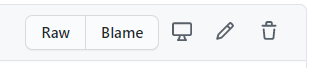

While Python provides a library to deal with HTTP queries (`urllib`), people often prefer using the 3rd-party `requests` because the usage is way simpler.


In [2]:
import requests

url = "https://raw.githubusercontent.com/openkinome/kinodata/master/data/KinHubKinaseList.csv"
response = requests.get(url)
response.raise_for_status()
response

<Response [200]>

When you use `requests.get(...)` you obtain a `Response` object. This is _not_ the file you want to download, but an object that wraps the HTTP query and the _response_ the server gave you. Before we inspect the contents, we always call `.raise_for_status()`, which will raise an exception if the server told us that the request could not be fulfilled. How does the server do that? With [HTTP status codes](https://en.wikipedia.org/wiki/List_of_HTTP_status_codes), a 3-digit number. There are several, but the most common ones are:

* 200: Everything OK!
* 404: File not found.
* 500: Server error.

`.raise_for_status()` will complain if your response didn't obtain a 200 code. As such, it's a good practice to call it after _every_ query!

See this example of bad URL, it contains a typo (there's no TXT file there, just a CSV):

In [3]:
bad_url = "https://raw.githubusercontent.com/openkinome/kinodata/master/data/KinHubKinaseList.txt"
bad_response = requests.get(bad_url)
bad_response.raise_for_status()
bad_response

HTTPError: 404 Client Error: Not Found for url: https://raw.githubusercontent.com/openkinome/kinodata/master/data/KinHubKinaseList.txt

Ok, now let's to the contents of the CSV file! Depending on what you are looking for, you will need one of these attributes:

* `response.content`: The _bytes_ returned by the server. 
* `response.text`: The contents of the file, as a string, if possible.
* `response.json()`: If the server returns JSON data (more on this later), this method will parse it and return the corresponding dictionary.

Which one should you use? If you want to display some _text_ in the Notebook output, then go for `.text`. Everything that involves binary files (images, archives, PDFs...) or downloading to disk should use `.content`.


Since this a CSV file, we know that's a plain text file, and then we can use the usual Python methods on it! Let's print the first 10 lines:

In [4]:
print(*response.text.splitlines()[:10], sep="\n")

﻿xName,Manning Name,HGNC Name,Kinase Name,Group,Family,SubFamily,UniprotID
ABL1,ABL,ABL1,Tyrosine-protein kinase ABL1,TK,Abl,,P00519
ACK,ACK,TNK2,Activated CDC42 kinase 1,TK,Ack,,Q07912
ACTR2,ACTR2,ACVR2A,Activin receptor type-2A,TKL,STKR,STKR2,P27037
ACTR2B,ACTR2B,ACVR2B,Activin receptor type-2B,TKL,STKR,STKR2,Q13705
ADCK4,ADCK4,ADCK4,Uncharacterized aarF domain-containing protein kinase 4,Atypical,ABC1,ABC1-A,Q96D53
Trb1,Trb1,TRIB1,Tribbles homolog 1,CAMK,Trbl,,Q96RU8
BRSK2,BRSK2,BRSK2,Serine/threonine-protein kinase BRSK2,CAMK,CAMKL,BRSK,Q8IWQ3
Wnk2,Wnk2,WNK2,Serine/threonine-protein kinase WNK2,Other,WNK,,Q9Y3S1
AKT1,AKT1,AKT1,RAC-alpha serine/threonine-protein kinase,AGC,Akt,,P31749


Of course, you can save this to disk using the usual Python constructs. Since we are _downloading_, it's recommended to use the raw bytes contents, not the text version! This means you should use `response.content` and open your file in bytes mode (the `b` in `wb`):

In [14]:
with open(TMPDATA / "kinhub.csv", "wb") as f:
    f.write(response.content)

# Open it again to check we wrote something
with open(TMPDATA / "kinhub.csv") as f:
    # Zip will stop iterating with the shortest iterator
    # passing `range(5)` allow us to just get five lines ;)
    for _, line in zip(range(5), f):
        print(line.rstrip())

﻿xName,Manning Name,HGNC Name,Kinase Name,Group,Family,SubFamily,UniprotID
ABL1,ABL,ABL1,Tyrosine-protein kinase ABL1,TK,Abl,,P00519
ACK,ACK,TNK2,Activated CDC42 kinase 1,TK,Ack,,Q07912
ACTR2,ACTR2,ACVR2A,Activin receptor type-2A,TKL,STKR,STKR2,P27037
ACTR2B,ACTR2B,ACVR2B,Activin receptor type-2B,TKL,STKR,STKR2,Q13705


ℹ Tip: if all you want to do is downloading a CSV file to open it with Pandas, then just pass the raw URL to `pandas.read_csv`. It will download the file for you!

In [15]:
import pandas as pd
df = pd.read_csv("https://raw.githubusercontent.com/openkinome/kinodata/master/data/KinHubKinaseList.csv")
df.head()

,xName,Manning Name,HGNC Name,Kinase Name,Group,Family,SubFamily,UniprotID
0,ABL1,ABL,ABL1,Tyrosine-protein kinase ABL1,TK,Abl,NaN,P00519
1,ACK,ACK,TNK2,Activated CDC42 kinase 1,TK,Ack,NaN,Q07912
2,ACTR2,ACTR2,ACVR2A,Activin receptor type-2A,TKL,STKR,STKR2,P27037
3,ACTR2B,ACTR2B,ACVR2B,Activin receptor type-2B,TKL,STKR,STKR2,Q13705
4,ADCK4,ADCK4,ADCK4,Uncharacterized aarF domain-containing protein...,Atypical,ABC1,ABC1-A,Q96D53


One note about file downloads. The method above downloads the whole file into memory, which can be a problem for very big files. If you intend to download a very large file, you can push it to disk directly using [streaming requests](https://requests.readthedocs.io/en/master/user/advanced/#streaming-requests) and [raw responses](https://2.python-requests.org/en/master/user/quickstart/#raw-response-content). As an example, let's pretend this [1MB video](https://archive.org/download/SlowMotionFlame/slomoflame_512kb.mp4) is _too big to fit in memory_:

In [35]:
import shutil
from IPython.display import Video

response = requests.get("https://archive.org/download/SlowMotionFlame/slomoflame_512kb.mp4", stream=True)
response.raise_for_status()

with open(TMPDATA / "video.mp4", "wb") as tmp:
    for chunk in response.iter_content(chunk_size=8192):
        tmp.write(chunk)
    
    # Let's play the movie in Jupyter! 
    # Paths passed to widgets need to be relative to notebook or they will 404 :)
    display(Video(Path(tmp.name).relative_to(HERE)))

### Accessing dynamically generated content

So far, we have been able to retrieve _files_ that were present on a remote server. To do that, we used `requests.get` and a URL that points to the file.

Well, it turns out that the same technique will work for many more types of content! What the server does with the URL is not our concern! Whether the server only needs to give you a file on disk or query a database and assemble different parts into the content returned does not matter at all. 

That concept alone is extremely powerful, as you will see now. Remember: **we just need to make sure we request the correct URL!**

Let's work on something fun now! The spike protein in the SARS-CoV-2 is one the most popular proteins lately, can we get some information from UniProt using `requests`? Its UniProt ID is `P0DTC2`. [Go check with your browser first](https://www.uniprot.org/uniprot/P0DTC2), you should see something like this:

![UniProt entry for SARS-CoV-2](images/uniprot-sars-cov-2.jpg)

One of the things UniProt provides is the aminoacid sequence of the listed protein. Scroll down until you see this part:

![Sequence for SARS-CoV-2](images/uniprot-sars-cov-2-sequence.jpg)

Do you think we can get the _only_ the sequence using Python? Let's see!

In [17]:
r = requests.get("https://www.uniprot.org/uniprot/P0DTC2")
r.raise_for_status()
print(r.text[:10000])

<!DOCTYPE html SYSTEM "about:legacy-compat">
<html xmlns="http://www.w3.org/1999/xhtml" lang="en" xml:lang="en"><head><title>S - Spike glycoprotein precursor - Severe acute respiratory syndrome coronavirus 2 (2019-nCoV) - S gene &amp; protein</title><meta content="IE=edge" http-equiv="X-UA-Compatible"/><meta content="text/html; charset=UTF-8" http-equiv="Content-Type"/><meta content="width=device-width, initial-scale=1" name="viewport"/><link href="/" rel="home"/><link href="https://creativecommons.org/licenses/by/4.0/" rel="license"/><link type="image/vnd.microsoft.icon" href="/favicon.ico" rel="shortcut icon"/><link href="/uniprot.min.css2020_06" type="text/css" rel="stylesheet"/><link href="/tippy.css" type="text/css" rel="stylesheet"/><script type="text/javascript">
			var BASE = '/';
		</script><script src="/js-compr.js2020_06" type="text/javascript"></script><script type="text/javascript">
				uniprot.isInternal = false;
				uniprot.namespace = 'uniprot';
				uniprot.releasedate 

Wow, what is all that noise? You are seeing the HTML contents of the webpage! That's the markup language web developers use to write webpages. There are libraries to process HTML and extract the actual content (like BeautifulSoup; more below), but we won't need it here now. Fortunately for us, UniProt provides alternative representations of the data:

![UniProt formats](images/uniprot-sars-cov-2-formats.jpg)

Some of them are more convenient for programmatic use. If you click on `Text` you will see something different in your browser: just plain text! Also, notice how the URL is now different:

* HTML representation (default): https://www.uniprot.org/uniprot/P0DTC2
* Text representation: https://www.uniprot.org/uniprot/P0DTC2.txt

Just adding the `.txt` extension was enough to change the style. This is a nice feature UniProt provides: it mimics a filesystem, but it's actually changing the representation of the content returned. Elegant! And more important, easier to use programmatically! Check it:

In [19]:
r = requests.get("https://www.uniprot.org/uniprot/P0DTC2.txt")
r.raise_for_status()
print(r.text[:1000])

ID   SPIKE_SARS2             Reviewed;        1273 AA.
AC   P0DTC2;
DT   22-APR-2020, integrated into UniProtKB/Swiss-Prot.
DT   22-APR-2020, sequence version 1.
DT   02-DEC-2020, entry version 5.
DE   RecName: Full=Spike glycoprotein {ECO:0000255|HAMAP-Rule:MF_04099};
DE            Short=S glycoprotein {ECO:0000255|HAMAP-Rule:MF_04099};
DE   AltName: Full=E2 {ECO:0000255|HAMAP-Rule:MF_04099};
DE   AltName: Full=Peplomer protein {ECO:0000255|HAMAP-Rule:MF_04099};
DE   Contains:
DE     RecName: Full=Spike protein S1 {ECO:0000255|HAMAP-Rule:MF_04099};
DE   Contains:
DE     RecName: Full=Spike protein S2 {ECO:0000255|HAMAP-Rule:MF_04099};
DE   Contains:
DE     RecName: Full=Spike protein S2' {ECO:0000255|HAMAP-Rule:MF_04099};
DE   Flags: Precursor;
GN   Name=S {ECO:0000255|HAMAP-Rule:MF_04099}; ORFNames=2;
OS   Severe acute respiratory syndrome coronavirus 2 (2019-nCoV) (SARS-CoV-2).
OC   Viruses; Riboviria; Orthornavirae; Pisuviricota; Pisoniviricetes;
OC   Nidovirales; Cornidovirineae; 

This is _exactly_ what we see on our browser! Plain text is nice for these things. However, the sequence is all the way at the end of the file. To retrieve it, you'd need to get creative and analyze those little tags each line has. See how it begins with `SQ` and finishes with `//`:

```
SQ   SEQUENCE   1273 AA;  141178 MW;  B17BE6D9F1C4EA34 CRC64;
     MFVFLVLLPL VSSQCVNLTT RTQLPPAYTN SFTRGVYYPD KVFRSSVLHS TQDLFLPFFS
     NVTWFHAIHV SGTNGTKRFD NPVLPFNDGV YFASTEKSNI IRGWIFGTTL DSKTQSLLIV
     NNATNVVIKV CEFQFCNDPF LGVYYHKNNK SWMESEFRVY SSANNCTFEY VSQPFLMDLE
     GKQGNFKNLR EFVFKNIDGY FKIYSKHTPI NLVRDLPQGF SALEPLVDLP IGINITRFQT
     LLALHRSYLT PGDSSSGWTA GAAAYYVGYL QPRTFLLKYN ENGTITDAVD CALDPLSETK
     CTLKSFTVEK GIYQTSNFRV QPTESIVRFP NITNLCPFGE VFNATRFASV YAWNRKRISN
     CVADYSVLYN SASFSTFKCY GVSPTKLNDL CFTNVYADSF VIRGDEVRQI APGQTGKIAD
     YNYKLPDDFT GCVIAWNSNN LDSKVGGNYN YLYRLFRKSN LKPFERDIST EIYQAGSTPC
     NGVEGFNCYF PLQSYGFQPT NGVGYQPYRV VVLSFELLHA PATVCGPKKS TNLVKNKCVN
     FNFNGLTGTG VLTESNKKFL PFQQFGRDIA DTTDAVRDPQ TLEILDITPC SFGGVSVITP
     GTNTSNQVAV LYQDVNCTEV PVAIHADQLT PTWRVYSTGS NVFQTRAGCL IGAEHVNNSY
     ECDIPIGAGI CASYQTQTNS PRRARSVASQ SIIAYTMSLG AENSVAYSNN SIAIPTNFTI
     SVTTEILPVS MTKTSVDCTM YICGDSTECS NLLLQYGSFC TQLNRALTGI AVEQDKNTQE
     VFAQVKQIYK TPPIKDFGGF NFSQILPDPS KPSKRSFIED LLFNKVTLAD AGFIKQYGDC
     LGDIAARDLI CAQKFNGLTV LPPLLTDEMI AQYTSALLAG TITSGWTFGA GAALQIPFAM
     QMAYRFNGIG VTQNVLYENQ KLIANQFNSA IGKIQDSLSS TASALGKLQD VVNQNAQALN
     TLVKQLSSNF GAISSVLNDI LSRLDKVEAE VQIDRLITGR LQSLQTYVTQ QLIRAAEIRA
     SANLAATKMS ECVLGQSKRV DFCGKGYHLM SFPQSAPHGV VFLHVTYVPA QEKNFTTAPA
     ICHDGKAHFP REGVFVSNGT HWFVTQRNFY EPQIITTDNT FVSGNCDVVI GIVNNTVYDP
     LQPELDSFKE ELDKYFKNHT SPDVDLGDIS GINASVVNIQ KEIDRLNEVA KNLNESLIDL
     QELGKYEQYI KWPWYIWLGF IAGLIAIVMV TIMLCCMTSC CSCLKGCCSC GSCCKFDEDD
     SEPVLKGVKL HYT
//
```

Hence, you could do something like this:

In [21]:
sequence_block = False
for line in r.text.splitlines():
    if line.startswith("SQ"):
        sequence_block = True
    elif line.startswith("//"):
        sequence_block = False
    
    if sequence_block:
        print(line)

SQ   SEQUENCE   1273 AA;  141178 MW;  B17BE6D9F1C4EA34 CRC64;
     MFVFLVLLPL VSSQCVNLTT RTQLPPAYTN SFTRGVYYPD KVFRSSVLHS TQDLFLPFFS
     NVTWFHAIHV SGTNGTKRFD NPVLPFNDGV YFASTEKSNI IRGWIFGTTL DSKTQSLLIV
     NNATNVVIKV CEFQFCNDPF LGVYYHKNNK SWMESEFRVY SSANNCTFEY VSQPFLMDLE
     GKQGNFKNLR EFVFKNIDGY FKIYSKHTPI NLVRDLPQGF SALEPLVDLP IGINITRFQT
     LLALHRSYLT PGDSSSGWTA GAAAYYVGYL QPRTFLLKYN ENGTITDAVD CALDPLSETK
     CTLKSFTVEK GIYQTSNFRV QPTESIVRFP NITNLCPFGE VFNATRFASV YAWNRKRISN
     CVADYSVLYN SASFSTFKCY GVSPTKLNDL CFTNVYADSF VIRGDEVRQI APGQTGKIAD
     YNYKLPDDFT GCVIAWNSNN LDSKVGGNYN YLYRLFRKSN LKPFERDIST EIYQAGSTPC
     NGVEGFNCYF PLQSYGFQPT NGVGYQPYRV VVLSFELLHA PATVCGPKKS TNLVKNKCVN
     FNFNGLTGTG VLTESNKKFL PFQQFGRDIA DTTDAVRDPQ TLEILDITPC SFGGVSVITP
     GTNTSNQVAV LYQDVNCTEV PVAIHADQLT PTWRVYSTGS NVFQTRAGCL IGAEHVNNSY
     ECDIPIGAGI CASYQTQTNS PRRARSVASQ SIIAYTMSLG AENSVAYSNN SIAIPTNFTI
     SVTTEILPVS MTKTSVDCTM YICGDSTECS NLLLQYGSFC TQLNRALTGI AVEQDKNTQE
     VFAQVKQIYK

Well, that mostly works. We still have some formatting we might want get rid of, like the multiple lines and the separator spaces...

In [22]:
sequence_block = False
lines = []
for line in r.text.splitlines():
    if line.startswith("SQ"):
        sequence_block = True
    elif line.startswith("//"):
        sequence_block = False
    
    if sequence_block:
        line = line.strip()  # delete spaces and newlines at the beginning and end of the line
        line = line.replace(" ", "") # delete spaces in the middle of the line
        lines.append(line)
sequence = "".join(lines[1:])  # the first line is the metadata header 
print(sequence)

MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHAIHVSGTNGTKRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLGVYYHKNNKSWMESEFRVYSSANNCTFEYVSQPFLMDLEGKQGNFKNLREFVFKNIDGYFKIYSKHTPINLVRDLPQGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKSTNLVKNKCVNFNFNGLTGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNTSNQVAVLYQDVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNSYECDIPIGAGICASYQTQTNSPRRARSVASQSIIAYTMSLGAENSVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGR

Ta-da! We got it! It required some processing, but it works... However, you should always wonder if there's an easier way. Given that Uniprot had a nice way of providing the text representation, how come they don't offer a URL that _only_ returns the sequence for a given UniProt ID? Well, they do! Just change `.txt` for `.fasta`: https://www.uniprot.org/uniprot/P0DTC2.fasta

In [23]:
r = requests.get("https://www.uniprot.org/uniprot/P0DTC2.fasta")
r.raise_for_status()
print(r.text)

>sp|P0DTC2|SPIKE_SARS2 Spike glycoprotein OS=Severe acute respiratory syndrome coronavirus 2 OX=2697049 GN=S PE=1 SV=1
MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFS
NVTWFHAIHVSGTNGTKRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIV
NNATNVVIKVCEFQFCNDPFLGVYYHKNNKSWMESEFRVYSSANNCTFEYVSQPFLMDLE
GKQGNFKNLREFVFKNIDGYFKIYSKHTPINLVRDLPQGFSALEPLVDLPIGINITRFQT
LLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETK
CTLKSFTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISN
CVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIAD
YNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPC
NGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKSTNLVKNKCVN
FNFNGLTGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITP
GTNTSNQVAVLYQDVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNSY
ECDIPIGAGICASYQTQTNSPRRARSVASQSIIAYTMSLGAENSVAYSNNSIAIPTNFTI
SVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQE
VFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDC
LGDIAARDLICAQKFNGLTVLPPLLTD

This is returned in FASTA, a common syntax in bioinformatics. You could use established libraries like BioPython to parse it too!

All these ways to access different representations or sections of the data contained in UniProt constitutes a URL-based API (Application Programmatic Interface). The foundational principle is that the URL contains all the **parameters** needed to ask the server for a specific type of content. Yes, you read that correctly: parameters. 

Let's compare it to a command-line interface:

```
@ # this is your browser
@ uniprot.org/uniprot/P0DTC2.fasta
```

```bash
$ # this is your terminal
$ uniprot --id=P0DTC2 --format=FASTA
```

Each part of the URL can be considered a positional argument! So, if you wanted the sequence of a different protein, just input its UniProt ID in the URL and bam, done! For example, `P00519` is the ID for the ABL1 kinase:

In [24]:
r = requests.get("https://www.uniprot.org/uniprot/P00519.fasta")
r.raise_for_status()
print(r.text)

>sp|P00519|ABL1_HUMAN Tyrosine-protein kinase ABL1 OS=Homo sapiens OX=9606 GN=ABL1 PE=1 SV=4
MLEICLKLVGCKSKKGLSSSSSCYLEEALQRPVASDFEPQGLSEAARWNSKENLLAGPSE
NDPNLFVALYDFVASGDNTLSITKGEKLRVLGYNHNGEWCEAQTKNGQGWVPSNYITPVN
SLEKHSWYHGPVSRNAAEYLLSSGINGSFLVRESESSPGQRSISLRYEGRVYHYRINTAS
DGKLYVSSESRFNTLAELVHHHSTVADGLITTLHYPAPKRNKPTVYGVSPNYDKWEMERT
DITMKHKLGGGQYGEVYEGVWKKYSLTVAVKTLKEDTMEVEEFLKEAAVMKEIKHPNLVQ
LLGVCTREPPFYIITEFMTYGNLLDYLRECNRQEVNAVVLLYMATQISSAMEYLEKKNFI
HRDLAARNCLVGENHLVKVADFGLSRLMTGDTYTAHAGAKFPIKWTAPESLAYNKFSIKS
DVWAFGVLLWEIATYGMSPYPGIDLSQVYELLEKDYRMERPEGCPEKVYELMRACWQWNP
SDRPSFAEIHQAFETMFQESSISDEVEKELGKQGVRGAVSTLLQAPELPTKTRTSRRAAE
HRDTTDVPEMPHSKGQGESDPLDHEPAVSPLLPRKERGPPEGGLNEDERLLPKDKKTNLF
SALIKKKKKTAPTPPKRSSSFREMDGQPERRGAGEEEGRDISNGALAFTPLDTADPAKSP
KPSNGAGVPNGALRESGGSGFRSPHLWKKSSTLTSSRLATGEEEGGGSSSKRFLRSCSAS
CVPHGAKDTEWRSVTLPRDLQSTGRQFDSSTFGGHKSEKPALPRKRAGENRSDQVTRGTV
TPPPRLVKKNEEAADEVFKDIMESSPGSSPPNLTPKPLRRQVTVAPASGLPHKEEAGKGS
ALGTPAAAEPVTPTSKAGSGAPGGTSKGPAEESRVRRHKHSSESPGRDKGKLS

So... what if we parameterize the URL with an f-string and provide a function to make it super Pythonic? 

In [25]:
def sequence_for_uniprot_id(uniprot_id):
    """
    Returns the FASTA sequence of a given Uniprot ID using
    the UniProt URL-based API
    """
    #                                                  ⬇ this is key part!
    r = requests.get(f"https://www.uniprot.org/uniprot/{uniprot_id}.fasta")
    r.raise_for_status()
    return r.text

Now you can use it for any UniProt ID. This is for the Src kinase:

In [27]:
print(sequence_for_uniprot_id("P12931"))

>sp|P12931|SRC_HUMAN Proto-oncogene tyrosine-protein kinase Src OS=Homo sapiens OX=9606 GN=SRC PE=1 SV=3
MGSNKSKPKDASQRRRSLEPAENVHGAGGGAFPASQTPSKPASADGHRGPSAAFAPAAAE
PKLFGGFNSSDTVTSPQRAGPLAGGVTTFVALYDYESRTETDLSFKKGERLQIVNNTEGD
WWLAHSLSTGQTGYIPSNYVAPSDSIQAEEWYFGKITRRESERLLLNAENPRGTFLVRES
ETTKGAYCLSVSDFDNAKGLNVKHYKIRKLDSGGFYITSRTQFNSLQQLVAYYSKHADGL
CHRLTTVCPTSKPQTQGLAKDAWEIPRESLRLEVKLGQGCFGEVWMGTWNGTTRVAIKTL
KPGTMSPEAFLQEAQVMKKLRHEKLVQLYAVVSEEPIYIVTEYMSKGSLLDFLKGETGKY
LRLPQLVDMAAQIASGMAYVERMNYVHRDLRAANILVGENLVCKVADFGLARLIEDNEYT
ARQGAKFPIKWTAPEAALYGRFTIKSDVWSFGILLTELTTKGRVPYPGMVNREVLDQVER
GYRMPCPPECPESLHDLMCQCWRKEPEERPTFEYLQAFLEDYFTSTEPQYQPGENL



Congratulations! You have used your first online API in Python!

#### Online APIs: Application Programming Interfaces

Modern web services are able to provide standardized ways to access their data, especially when it comes to databases. This usually means that you can access a specific URL in their site to request results that are __machine readable__.

For example, [UniProt](https://www.uniprot.org/) is a database for all types of information concerning proteins. If you look for a specific protein, like `Src` (involved in cancer), you will arrive at [this beautiful webpage](https://www.uniprot.org/uniprot/P12931) with well organized content sections. If you add `.fasta` to the URL, however, you will obtain the protein sequence in `FASTA` format.

```
https://www.uniprot.org/uniprot/P12931 -> https://www.uniprot.org/uniprot/P12931.fasta
---

>sp|P12931|SRC_HUMAN Proto-oncogene tyrosine-protein kinase Src OS=Homo sapiens OX=9606 GN=SRC PE=1 SV=3
MGSNKSKPKDASQRRRSLEPAENVHGAGGGAFPASQTPSKPASADGHRGPSAAFAPAAAE
PKLFGGFNSSDTVTSPQRAGPLAGGVTTFVALYDYESRTETDLSFKKGERLQIVNNTEGD
WWLAHSLSTGQTGYIPSNYVAPSDSIQAEEWYFGKITRRESERLLLNAENPRGTFLVRES
ETTKGAYCLSVSDFDNAKGLNVKHYKIRKLDSGGFYITSRTQFNSLQQLVAYYSKHADGL
CHRLTTVCPTSKPQTQGLAKDAWEIPRESLRLEVKLGQGCFGEVWMGTWNGTTRVAIKTL
KPGTMSPEAFLQEAQVMKKLRHEKLVQLYAVVSEEPIYIVTEYMSKGSLLDFLKGETGKY
LRLPQLVDMAAQIASGMAYVERMNYVHRDLRAANILVGENLVCKVADFGLARLIEDNEYT
ARQGAKFPIKWTAPEAALYGRFTIKSDVWSFGILLTELTTKGRVPYPGMVNREVLDQVER
GYRMPCPPECPESLHDLMCQCWRKEPEERPTFEYLQAFLEDYFTSTEPQYQPGENL

```

This is a way to provide programmatic access to a web service: through specific URL schemes. However, each web service would have to come up with their own scheme, which will force the developers to implement their scripts on a case-by-case basis.

Fortunately, there are some standardized ways to provide this kind of programmatic access:

- HTTP-based RESTful APIs ([wiki](https://en.wikipedia.org/wiki/Representational_state_transfer#Applied_to_Web_services))
- GraphQL
- SOAP
- gRPC

In this talktorial, we will only use REST and SOAP APIs.

##### HTTP-based RESTful APIs

This type of programmatic access/provision defines a specific entry point for clients (scripts, libraries, programs) that require programmatic access, something like `api.webservice.com`. They can be versioned, so the provider can update the scheme without disrupting existing implementations (`api.webservice.com/v1` will still work even when `api.webservice.com/v2` has been deployed).

This kind of APIs is usually accompanied by well-written documentation explaining all the available actions in the platform. For example, look at the [GitHub REST API for listing repositories](https://developer.github.com/v3/repos/#list-organization-repositories). You can see how every argument and option is documented, along with usage examples. 

The only difficulty is to build the needed URLs in the correct way:

```
https://api.github.com/users/volkamerlab/repos
```

<details>
    <summary>
        Returns (click here!)
    </summary>

```
[
  {
    "id": 156864288,
    "node_id": "MDEwOlJlcG9zaXRvcnkxNTY4NjQyODg=",
    "name": "TeachOpenCADD",
    "full_name": "volkamerlab/TeachOpenCADD",
    "private": false,
    "owner": {
      "login": "volkamerlab",
      "id": 44878588,
      "node_id": "MDEyOk9yZ2FuaXphdGlvbjQ0ODc4NTg4",
      "avatar_url": "https://avatars2.githubusercontent.com/u/44878588?v=4",
      "gravatar_id": "",
      "url": "https://api.github.com/users/volkamerlab",
      "html_url": "https://github.com/volkamerlab",
      "followers_url": "https://api.github.com/users/volkamerlab/followers",
      "following_url": "https://api.github.com/users/volkamerlab/following{/other_user}",
      "gists_url": "https://api.github.com/users/volkamerlab/gists{/gist_id}",
      "starred_url": "https://api.github.com/users/volkamerlab/starred{/owner}{/repo}",
      "subscriptions_url": "https://api.github.com/users/volkamerlab/subscriptions",
      "organizations_url": "https://api.github.com/users/volkamerlab/orgs",
      "repos_url": "https://api.github.com/users/volkamerlab/repos",
      "events_url": "https://api.github.com/users/volkamerlab/events{/privacy}",
      "received_events_url": "https://api.github.com/users/volkamerlab/received_events",
      "type": "Organization",
      "site_admin": false
    },
    "html_url": "https://github.com/volkamerlab/TeachOpenCADD",
    "description": "TeachOpenCADD: a teaching platform for computer-aided drug design (CADD) using open source packages and data",
    "fork": false,
    "url": "https://api.github.com/repos/volkamerlab/TeachOpenCADD",
    "forks_url": "https://api.github.com/repos/volkamerlab/TeachOpenCADD/forks",
    "keys_url": "https://api.github.com/repos/volkamerlab/TeachOpenCADD/keys{/key_id}",
    "collaborators_url": "https://api.github.com/repos/volkamerlab/TeachOpenCADD/collaborators{/collaborator}",
    "teams_url": "https://api.github.com/repos/volkamerlab/TeachOpenCADD/teams",
    "hooks_url": "https://api.github.com/repos/volkamerlab/TeachOpenCADD/hooks",
    "issue_events_url": "https://api.github.com/repos/volkamerlab/TeachOpenCADD/issues/events{/number}",
    "events_url": "https://api.github.com/repos/volkamerlab/TeachOpenCADD/events",
    "assignees_url": "https://api.github.com/repos/volkamerlab/TeachOpenCADD/assignees{/user}",
    "branches_url": "https://api.github.com/repos/volkamerlab/TeachOpenCADD/branches{/branch}",
    "tags_url": "https://api.github.com/repos/volkamerlab/TeachOpenCADD/tags",
    "blobs_url": "https://api.github.com/repos/volkamerlab/TeachOpenCADD/git/blobs{/sha}",
    "git_tags_url": "https://api.github.com/repos/volkamerlab/TeachOpenCADD/git/tags{/sha}",
    "git_refs_url": "https://api.github.com/repos/volkamerlab/TeachOpenCADD/git/refs{/sha}",
    "trees_url": "https://api.github.com/repos/volkamerlab/TeachOpenCADD/git/trees{/sha}",
    "statuses_url": "https://api.github.com/repos/volkamerlab/TeachOpenCADD/statuses/{sha}",
    "languages_url": "https://api.github.com/repos/volkamerlab/TeachOpenCADD/languages",
    "stargazers_url": "https://api.github.com/repos/volkamerlab/TeachOpenCADD/stargazers",
    "contributors_url": "https://api.github.com/repos/volkamerlab/TeachOpenCADD/contributors",
    "subscribers_url": "https://api.github.com/repos/volkamerlab/TeachOpenCADD/subscribers",
    "subscription_url": "https://api.github.com/repos/volkamerlab/TeachOpenCADD/subscription",
    "commits_url": "https://api.github.com/repos/volkamerlab/TeachOpenCADD/commits{/sha}",
    "git_commits_url": "https://api.github.com/repos/volkamerlab/TeachOpenCADD/git/commits{/sha}",
    "comments_url": "https://api.github.com/repos/volkamerlab/TeachOpenCADD/comments{/number}",
    "issue_comment_url": "https://api.github.com/repos/volkamerlab/TeachOpenCADD/issues/comments{/number}",
    "contents_url": "https://api.github.com/repos/volkamerlab/TeachOpenCADD/contents/{+path}",
    "compare_url": "https://api.github.com/repos/volkamerlab/TeachOpenCADD/compare/{base}...{head}",
    "merges_url": "https://api.github.com/repos/volkamerlab/TeachOpenCADD/merges",
    "archive_url": "https://api.github.com/repos/volkamerlab/TeachOpenCADD/{archive_format}{/ref}",
    "downloads_url": "https://api.github.com/repos/volkamerlab/TeachOpenCADD/downloads",
    "issues_url": "https://api.github.com/repos/volkamerlab/TeachOpenCADD/issues{/number}",
    "pulls_url": "https://api.github.com/repos/volkamerlab/TeachOpenCADD/pulls{/number}",
    "milestones_url": "https://api.github.com/repos/volkamerlab/TeachOpenCADD/milestones{/number}",
    "notifications_url": "https://api.github.com/repos/volkamerlab/TeachOpenCADD/notifications{?since,all,participating}",
    "labels_url": "https://api.github.com/repos/volkamerlab/TeachOpenCADD/labels{/name}",
    "releases_url": "https://api.github.com/repos/volkamerlab/TeachOpenCADD/releases{/id}",
    "deployments_url": "https://api.github.com/repos/volkamerlab/TeachOpenCADD/deployments",
    "created_at": "2018-11-09T13:15:15Z",
    "updated_at": "2019-07-18T02:36:48Z",
    "pushed_at": "2019-05-03T15:02:03Z",
    "git_url": "git://github.com/volkamerlab/TeachOpenCADD.git",
    "ssh_url": "git@github.com:volkamerlab/TeachOpenCADD.git",
    "clone_url": "https://github.com/volkamerlab/TeachOpenCADD.git",
    "svn_url": "https://github.com/volkamerlab/TeachOpenCADD",
    "homepage": null,
    "size": 28121,
    "stargazers_count": 39,
    "watchers_count": 39,
    "language": "Jupyter Notebook",
    "has_issues": true,
    "has_projects": true,
    "has_downloads": true,
    "has_wiki": true,
    "has_pages": false,
    "forks_count": 13,
    "mirror_url": null,
    "archived": false,
    "disabled": false,
    "open_issues_count": 0,
    "license": {
      "key": "cc-by-4.0",
      "name": "Creative Commons Attribution 4.0 International",
      "spdx_id": "CC-BY-4.0",
      "url": "https://api.github.com/licenses/cc-by-4.0",
      "node_id": "MDc6TGljZW5zZTI1"
    },
    "forks": 13,
    "open_issues": 0,
    "watchers": 39,
    "default_branch": "master"
  }
]
```
</details>

This happens to be a [JSON](https://en.wikipedia.org/wiki/JSON)-formatted dictionary! This is easily parsed into a Python dictionary using the `json` library. The best news is that you don't even need that. Using `requests`, the following operation can be done in three lines:

In [1]:
import requests

response = requests.get("https://api.github.com/users/volkamerlab/repos")
response.raise_for_status()  # this line checks for potential errors
result = response.json()
result

[{'id': 222449034,
  'node_id': 'MDEwOlJlcG9zaXRvcnkyMjI0NDkwMzQ=',
  'name': 'ai_in_medicine',
  'full_name': 'volkamerlab/ai_in_medicine',
  'private': False,
  'owner': {'login': 'volkamerlab',
   'id': 44878588,
   'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0ODc4NTg4',
   'avatar_url': 'https://avatars2.githubusercontent.com/u/44878588?v=4',
   'gravatar_id': '',
   'url': 'https://api.github.com/users/volkamerlab',
   'html_url': 'https://github.com/volkamerlab',
   'followers_url': 'https://api.github.com/users/volkamerlab/followers',
   'following_url': 'https://api.github.com/users/volkamerlab/following{/other_user}',
   'gists_url': 'https://api.github.com/users/volkamerlab/gists{/gist_id}',
   'starred_url': 'https://api.github.com/users/volkamerlab/starred{/owner}{/repo}',
   'subscriptions_url': 'https://api.github.com/users/volkamerlab/subscriptions',
   'organizations_url': 'https://api.github.com/users/volkamerlab/orgs',
   'repos_url': 'https://api.github.com/users/volkamerlab/

If you parameterize the URL with an `f-string`, then you can design a function that will list the repositories of any user:

In [2]:
def repos(username):
    response = requests.get(f"https://api.github.com/users/{username}/repos")
    response.raise_for_status()
    return response.json()


repos("volkamerlab")

[{'id': 222449034,
  'node_id': 'MDEwOlJlcG9zaXRvcnkyMjI0NDkwMzQ=',
  'name': 'ai_in_medicine',
  'full_name': 'volkamerlab/ai_in_medicine',
  'private': False,
  'owner': {'login': 'volkamerlab',
   'id': 44878588,
   'node_id': 'MDEyOk9yZ2FuaXphdGlvbjQ0ODc4NTg4',
   'avatar_url': 'https://avatars2.githubusercontent.com/u/44878588?v=4',
   'gravatar_id': '',
   'url': 'https://api.github.com/users/volkamerlab',
   'html_url': 'https://github.com/volkamerlab',
   'followers_url': 'https://api.github.com/users/volkamerlab/followers',
   'following_url': 'https://api.github.com/users/volkamerlab/following{/other_user}',
   'gists_url': 'https://api.github.com/users/volkamerlab/gists{/gist_id}',
   'starred_url': 'https://api.github.com/users/volkamerlab/starred{/owner}{/repo}',
   'subscriptions_url': 'https://api.github.com/users/volkamerlab/subscriptions',
   'organizations_url': 'https://api.github.com/users/volkamerlab/orgs',
   'repos_url': 'https://api.github.com/users/volkamerlab/

##### Generating a client for any API

Did you find that convenient? Well, we are not done yet!

The REST API schema can be expressed programmatically in a document called [Swagger/OpenAPI definitions](https://swagger.io/docs/specification/about/), which allows to dynamically generate a Python client for any REST API that implements the Swagger/OpenAPI schema. [This is the one for GitHub](https://api.apis.guru/v2/specs/github.com/v3/swagger.json).

Of course, there are libraries for doing that in Python:

- `bravado`
- `agithub`

Using Bravado:

In [9]:
from bravado.client import SwaggerClient

# unofficial, lightweight API
GITHUB_SWAGGER = "https://raw.githubusercontent.com/APIs-guru/openapi-directory/eb36b28598eff2cb76008475168e9d0657a51dc4/APIs/github.com/v3/swagger.yaml"
client = SwaggerClient.from_url(GITHUB_SWAGGER)
client

SwaggerClient(https://api.github.com/)

Then, you can have fun inspecting the `client` object for all the API actions as methods. We will see an actual example with [KLIFS](http://klifs.vu-compmedchem.nl) in the case study.

__Tip__: Use `client?` to inspect the client in this Notebook.

Other standards like SOAP operate on a very similar principle: all you need to provide is a definition file to be processed by a client-generating library. For SOAP, the definition files are formatted as `.wsdl`. One of the most popular libraries is `suds` (now installable as `suds-community`).

In [12]:
import suds.client

wsdl = "https://gist.githubusercontent.com/akula1001/9744919/raw/917915efc875effaf0ddb128fe9c18f406f12186/math.wsdl"
client = suds.client.Client(wsdl)
# Suds does not populate the __docstring__ (accessed via ?), but overloads the __str__() method
# In other words, you have to "print" the object to get the documentation
print(client)


Suds ( https://fedorahosted.org/suds/ )  version: 0.8.4

Service ( MathService ) tns="http://example.org/math"
   Prefixes (0)
   Ports (1):
      (MathEndpoint)
         Methods (1):
            sum(xs:double x, xs:double y)
         Types (0):




#### Document parsing

Sometimes you won't be as lucky and the web service won't provide a standardized API that produces machine-readable documents. Instead, you will have to use the regular webpage and parse through the HTML code to obtain the information you need. This is called (web) __scraping__, which usually involves finding the right HTML tags and IDs that contain the valuable data (ignoring things such as the sidebars, top menus, footers, ads, etc).

In scraping, you basically do two things:

1. Access the webpage with `requests` and obtain the HTML contents.
2. Parse the HTML string with `BeautifulSoup` or `requests-html`.


Let's parse the proteinogenic amino acids table in this [Wikipedia article](https://en.wikipedia.org/wiki/Proteinogenic_amino_acid):

In [13]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

r = requests.get("https://en.wikipedia.org/wiki/Proteinogenic_amino_acid")
r.raise_for_status()

# To guess the correct steps here, you will have to inspect the HTML code by hand
# Tip: use right-click + inspect content in any webpage to land in the HTML definition ;)
html = BeautifulSoup(r.text)
header = html.find("span", id="General_chemical_properties")
table = header.find_all_next()[4]
table_body = table.find("tbody")

data = []
for row in table_body.find_all("tr"):
    cells = row.find_all("td")
    if cells:
        data.append([])
    for cell in cells:
        cell_content = cell.text.strip()
        try:  # convert to float if possible
            cell_content = float(cell_content)
        except ValueError:
            pass
        data[-1].append(cell_content)
pd.DataFrame.from_records(data)

,0,1,2,3,4,5
0,A,Ala,89.09404,6.01,2.35,9.87
1,C,Cys,121.15404,5.05,1.92,10.7
2,D,Asp,133.10384,2.85,1.99,9.9
3,E,Glu,147.13074,3.15,2.1,9.47
4,F,Phe,165.19184,5.49,2.2,9.31
5,G,Gly,75.06714,6.06,2.35,9.78
6,H,His,155.15634,7.6,1.8,9.33
7,I,Ile,131.17464,6.05,2.32,9.76
8,K,Lys,146.18934,9.6,2.16,9.06
9,L,Leu,131.17464,6.01,2.33,9.74


#### Browser remote control

The trend some years ago was to build servers that dynamically-generated HTML documents with some JavaScript here and there (such as Wikipedia). In other words, the HTML is built in the server and sent to the client (your browser).

However, latest trends are pointing towards full applications built entirely with JavaScript frameworks. This means that the HTML content is dynamically generated in the client. Traditional parsing won't work and you will only download the placeholder HTML code that hosts the JavaScript framework. To work around this, the HTML must be rendered with a client-side JavaScript engine.

We won't cover this in the current notebook, but you can check the following projects if you are interested:

- [puppeteer](https://github.com/GoogleChrome/puppeteer)
- [selenium](https://www.seleniumhq.org/)

## Practical

***

## Discussion

In this theoretical introduction you have seen how different methods to programmatically access online web services can be used from a Python interpreter. Leveraging these techniques you will be able to build automated pipelines inside Jupyter Notebooks. Keep reading on the following parts of this talktorial to see an example applied to CADD.

## Quiz

* How can you find the correct HTML tags and identifiers to scrape a specific part of a website? Can it be automated?
* Would you rather use programmatic APIs or manually crafted scrapers?